In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/cifar-10/trainLabels.csv
/kaggle/input/cifar-10/sampleSubmission.csv
/kaggle/input/cifar-10/test.7z
/kaggle/input/cifar-10/train.7z


In [2]:
!pip install py7zr

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.7/69.7 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 96.4/96.4 kB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 141.3/141.3 kB 10.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 428.8/428.8 kB 16.8 MB/s eta 0:00:00


# Setup and Data Loading

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torchvision.models as models
import pandas as pd
import numpy as np
from PIL import Image
import os
import py7zr
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

In [4]:
# Check for GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [5]:
# Extract 7z files
def extract_7z_files():
    train_path = "/kaggle/input/cifar-10/train.7z"
    test_path = "/kaggle/input/cifar-10/test.7z"
    
    if not os.path.exists("/kaggle/working/train"):
        print("Extracting train.7z...")
        with py7zr.SevenZipFile(train_path, mode='r') as z:
            z.extractall("./")
    
    if not os.path.exists("/kaggle/working/test"):
        print("Extracting test.7z...")
        with py7zr.SevenZipFile(test_path, mode='r') as z:
            z.extractall("./")

extract_7z_files()

Extracting train.7z...
Extracting test.7z...


# Dataset Classes and Data Loaders

In [6]:
class CIFAR10TrainDataset(Dataset):
    def __init__(self, labels_df, img_dir, transform=None):
        self.labels_df = labels_df
        self.img_dir = img_dir
        self.transform = transform
        
        self.classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 
                       'dog', 'frog', 'horse', 'ship', 'truck']
        self.class_to_idx = {cls: idx for idx, cls in enumerate(self.classes)}
        
    def __len__(self):
        return len(self.labels_df)
    
    def __getitem__(self, idx):
        img_name = f"{self.labels_df.iloc[idx]['id']}.png"
        img_path = os.path.join(self.img_dir, img_name)
        
        image = Image.open(img_path).convert('RGB')
        label_name = self.labels_df.iloc[idx]['label']
        label = self.class_to_idx[label_name]
        
        if self.transform:
            image = self.transform(image)
            
        return image, label

class CIFAR10TestDataset(Dataset):
    def __init__(self, img_dir, transform=None):
        self.img_dir = img_dir
        self.transform = transform
        self.image_files = [f for f in os.listdir(img_dir) if f.endswith('.png')]
        self.image_files.sort(key=lambda x: int(x.split('.')[0]))
        
    def __len__(self):
        return len(self.image_files)
    
    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.image_files[idx])
        image = Image.open(img_path).convert('RGB')
        img_id = int(self.image_files[idx].split('.')[0])
        
        if self.transform:
            image = self.transform(image)
            
        return image, img_id

# data augmentation for ResNet
train_transform = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.1),
    transforms.RandomRotation(15),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

val_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

# Load data
labels_df = pd.read_csv("/kaggle/input/cifar-10/trainLabels.csv")
train_df, val_df = train_test_split(
    labels_df, test_size=0.2, random_state=42, stratify=labels_df['label']
)

train_dataset = CIFAR10TrainDataset(train_df, "/kaggle/working/train", transform=train_transform)
val_dataset = CIFAR10TrainDataset(val_df, "/kaggle/working/train", transform=val_transform)
test_dataset = CIFAR10TestDataset("/kaggle/working/test", transform=val_transform)

batch_size = 128
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)

# ResNet-18 for CIFAR-10

In [7]:
def create_resnet18_model(num_classes=10, pretrained=True, fine_tune_method='full'):
    """
    Create ResNet-18 model modified for CIFAR-10
    
    Args:
        num_classes: Number of output classes (10 for CIFAR-10)
        pretrained: Use pre-trained weights on ImageNet
        fine_tune_method: 
            'full' - fine-tune all layers
            'last_layer' - only train the last layer
            'progressive' - progressively unfreeze layers
    """
    # Load pre-trained ResNet-18
    model = models.resnet18(pretrained=pretrained)
    
    # Modify the first convolutional layer for CIFAR-10 (32x32 images)
    # Original ResNet expects 224x224, but CIFAR-10 is 32x32
    # We change the first conv layer to use smaller kernel and stride
    model.conv1 = nn.Conv2d(
        3, 64, kernel_size=3, stride=1, padding=1, bias=False
    )
    
    # Remove the initial maxpool layer since CIFAR-10 images are small
    model.maxpool = nn.Identity()
    
    # Modify the final fully connected layer
    in_features = model.fc.in_features
    model.fc = nn.Linear(in_features, num_classes)
    
    # Apply fine-tuning strategy
    if fine_tune_method == 'last_layer':
        # Freeze all layers except the final one
        for param in model.parameters():
            param.requires_grad = False
        for param in model.fc.parameters():
            param.requires_grad = True
            
    elif fine_tune_method == 'progressive':
        # Freeze early layers, fine-tune later layers
        # Layer groups for progressive unfreezing
        layer_groups = [
            model.conv1,
            model.bn1,
            model.layer1,
            model.layer2,
            model.layer3,
            model.layer4,
            model.fc
        ]
        
        # Initially freeze all layers
        for param in model.parameters():
            param.requires_grad = False
            
        # Unfreeze the last two layers and classifier
        for param in model.layer3.parameters():
            param.requires_grad = True
        for param in model.layer4.parameters():
            param.requires_grad = True
        for param in model.fc.parameters():
            param.requires_grad = True
    
    # 'full' fine-tuning keeps all layers trainable (default)
    
    return model.to(device)

# Alternative: ResNet-18 with more modifications for CIFAR-10
class CIFAR10ResNet18(nn.Module):
    def __init__(self, num_classes=10, pretrained=True):
        super(CIFAR10ResNet18, self).__init__()
        
        # Load pre-trained ResNet-18
        self.model = models.resnet18(pretrained=pretrained)
        
        # Modify for CIFAR-10
        self.model.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.model.bn1 = nn.BatchNorm2d(64)
        self.model.maxpool = nn.Identity()  # Remove maxpool
        
        # Add dropout for regularization
        self.dropout = nn.Dropout(0.2)
        
        # Modify final layer
        in_features = self.model.fc.in_features
        self.model.fc = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(in_features, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.3),
            nn.Linear(512, num_classes)
        )
        
    def forward(self, x):
        return self.model(x)

# Training Functions with Fine-tuning Strategies

In [8]:
def train_epoch(model, loader, criterion, optimizer):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    pbar = tqdm(loader, desc="Training")
    for batch_idx, (inputs, targets) in enumerate(pbar):
        inputs, targets = inputs.to(device, non_blocking=True), targets.to(device, non_blocking=True)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()
        
        pbar.set_postfix({
            'Loss': f"{running_loss/(batch_idx+1):.3f}",
            'Acc': f"{100.*correct/total:.2f}%"
        })
    
    epoch_loss = running_loss / len(loader)
    epoch_acc = 100. * correct / total
    return epoch_loss, epoch_acc

def validate_epoch(model, loader, criterion):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        pbar = tqdm(loader, desc="Validation")
        for batch_idx, (inputs, targets) in enumerate(pbar):
            inputs, targets = inputs.to(device, non_blocking=True), targets.to(device, non_blocking=True)
            
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            
            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
            
            pbar.set_postfix({
                'Loss': f"{running_loss/(batch_idx+1):.3f}",
                'Acc': f"{100.*correct/total:.2f}%"
            })
    
    epoch_loss = running_loss / len(loader)
    epoch_acc = 100. * correct / total
    return epoch_loss, epoch_acc

def fine_tune_resnet(model, train_loader, val_loader, epochs=50, initial_lr=0.001, 
                    fine_tune_method='full', patience=10):
    """
    Fine-tune ResNet-18 with different strategies
    """
    # Different learning rates for different parts of the network
    if fine_tune_method == 'last_layer':
        # Only train the last layer with higher LR
        optimizer = optim.Adam(model.fc.parameters(), lr=initial_lr, weight_decay=1e-4)
        
    elif fine_tune_method == 'progressive':
        # Different LRs for different layers
        params = [
            {'params': model.layer3.parameters(), 'lr': initial_lr/10},
            {'params': model.layer4.parameters(), 'lr': initial_lr/10},
            {'params': model.fc.parameters(), 'lr': initial_lr}
        ]
        optimizer = optim.Adam(params, weight_decay=1e-4)
        
    else:  # 'full' fine-tuning
        optimizer = optim.Adam(model.parameters(), lr=initial_lr, weight_decay=1e-4)
    
    # Learning rate scheduler
    scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(
        optimizer, T_0=10, T_mult=2, eta_min=1e-6
    )
    
    # Loss function
    criterion = nn.CrossEntropyLoss(label_smoothing=0.1)  # Label smoothing for better generalization
    
    # Early stopping
    best_val_acc = 0
    epochs_no_improve = 0
    early_stop = False
    
    train_losses, val_losses = [], []
    train_accs, val_accs = [], []
    
    print(f"Starting fine-tuning with method: {fine_tune_method}")
    print(f"Trainable parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}")
    
    for epoch in range(epochs):
        if early_stop:
            print(f"Early stopping triggered after {epoch} epochs")
            break
            
        print(f'\nEpoch {epoch+1}/{epochs}')
        print('-' * 50)
        
        # Progressive unfreezing (if using progressive method)
        if fine_tune_method == 'progressive' and epoch == 15:
            print("Unfreezing layer2 for fine-tuning...")
            for param in model.layer2.parameters():
                param.requires_grad = True
            # Update optimizer
            params = [
                {'params': model.layer2.parameters(), 'lr': initial_lr/100},
                {'params': model.layer3.parameters(), 'lr': initial_lr/10},
                {'params': model.layer4.parameters(), 'lr': initial_lr/10},
                {'params': model.fc.parameters(), 'lr': initial_lr}
            ]
            optimizer = optim.Adam(params, weight_decay=1e-4)
            scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(
                optimizer, T_0=10, T_mult=2, eta_min=1e-6
            )
        
        # Train
        train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer)
        
        # Validate
        val_loss, val_acc = validate_epoch(model, val_loader, criterion)
        
        # Update learning rate
        scheduler.step()
        
        # Save metrics
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accs.append(train_acc)
        val_accs.append(val_acc)
        
        # Check for improvement
        if val_acc > best_val_acc + 0.001:  # min_delta of 0.1%
            best_val_acc = val_acc
            epochs_no_improve = 0
            
            # Save best model
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'scheduler_state_dict': scheduler.state_dict(),
                'val_acc': val_acc,
                'train_acc': train_acc,
                'val_loss': val_loss,
                'train_loss': train_loss,
            }, '/kaggle/working/best_resnet18_model.pth')
            print(f' New best model saved with validation accuracy: {val_acc:.2f}%')
        else:
            epochs_no_improve += 1
            print(f' No improvement for {epochs_no_improve} epoch(s)')
            
            if epochs_no_improve >= patience:
                early_stop = True
                print(f"Early stopping: No improvement for {patience} consecutive epochs")
        
        current_lr = scheduler.get_last_lr()[0]
        print(f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%')
        print(f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%')
        print(f'Best Val Acc: {best_val_acc:.2f}%')
        print(f'Learning Rate: {current_lr:.6f}')
        print(f'Early Stop Counter: {epochs_no_improve}/{patience}')
    
    # Load best model
    checkpoint = torch.load('/kaggle/working/best_resnet18_model.pth')
    model.load_state_dict(checkpoint['model_state_dict'])
    print(f"\nTraining completed! Best validation accuracy: {checkpoint['val_acc']:.2f}%")
    
    # Plot results
    plot_training_results(train_losses, val_losses, train_accs, val_accs, checkpoint)
    
    return model, checkpoint

def plot_training_results(train_losses, val_losses, train_accs, val_accs, checkpoint):
    plt.figure(figsize=(15, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss', linewidth=2)
    plt.plot(val_losses, label='Val Loss', linewidth=2)
    plt.axvline(x=checkpoint['epoch'], color='r', linestyle='--', alpha=0.7, label='Best Model')
    plt.legend()
    plt.title('ResNet-18: Loss over epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid(True, alpha=0.3)
    
    plt.subplot(1, 2, 2)
    plt.plot(train_accs, label='Train Acc', linewidth=2)
    plt.plot(val_accs, label='Val Acc', linewidth=2)
    plt.axvline(x=checkpoint['epoch'], color='r', linestyle='--', alpha=0.7, label='Best Model')
    plt.axhline(y=checkpoint['val_acc'], color='g', linestyle='-', alpha=0.5, 
                label=f'Best Val Acc: {checkpoint["val_acc"]:.2f}%')
    plt.legend()
    plt.title('ResNet-18: Accuracy over epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('/kaggle/working/resnet18_training_history.png', dpi=300, bbox_inches='tight')
    plt.show()

# Two-Stage Fine-tuning Strategy

In [9]:
def two_stage_fine_tuning():
    """
    Two-stage fine-tuning:
    Stage 1: Train only the classifier head with frozen backbone
    Stage 2: Fine-tune the entire network with lower learning rate
    """
    print("=== Stage 1: Training Classifier Head ===")
    # First, train only the final layers with frozen backbone
    model_stage1 = create_resnet18_model(
        num_classes=10, 
        pretrained=True, 
        fine_tune_method='last_layer'
    )
    
    # Train classifier head
    model_stage1, checkpoint_stage1 = fine_tune_resnet(
        model_stage1, train_loader, val_loader, 
        epochs=20, initial_lr=0.01, fine_tune_method='last_layer', patience=7
    )
    
    print("\n=== Stage 2: Full Network Fine-tuning ===")
    # Now unfreeze all layers and fine-tune with lower learning rate
    for param in model_stage1.parameters():
        param.requires_grad = True
    
    model_stage2, checkpoint_stage2 = fine_tune_resnet(
        model_stage1, train_loader, val_loader,
        epochs=1000, initial_lr=0.0001, fine_tune_method='full', patience=10
    )
    
    return model_stage2, checkpoint_stage2

# Main Execution

=== Two-Stage Fine-tuning Strategy ===
=== Stage 1: Training Classifier Head ===


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 177MB/s]


Starting fine-tuning with method: last_layer
Trainable parameters: 5,130

Epoch 1/20
--------------------------------------------------


Validation: 100%|██████████| 79/79 [00:04<00:00, 19.60it/s, Loss=1.869, Acc=39.59%]


 New best model saved with validation accuracy: 39.59%
Train Loss: 2.1355, Train Acc: 31.93%
Val Loss: 1.8691, Val Acc: 39.59%
Best Val Acc: 39.59%
Learning Rate: 0.009755
Early Stop Counter: 0/7

Epoch 2/20
--------------------------------------------------


Validation: 100%|██████████| 79/79 [00:03<00:00, 20.49it/s, Loss=1.999, Acc=39.18%]


 No improvement for 1 epoch(s)
Train Loss: 2.0234, Train Acc: 34.55%
Val Loss: 1.9986, Val Acc: 39.18%
Best Val Acc: 39.59%
Learning Rate: 0.009045
Early Stop Counter: 1/7

Epoch 3/20
--------------------------------------------------


Validation: 100%|██████████| 79/79 [00:03<00:00, 20.72it/s, Loss=1.946, Acc=38.54%]


 No improvement for 2 epoch(s)
Train Loss: 2.0037, Train Acc: 35.03%
Val Loss: 1.9457, Val Acc: 38.54%
Best Val Acc: 39.59%
Learning Rate: 0.007939
Early Stop Counter: 2/7

Epoch 4/20
--------------------------------------------------


Validation: 100%|██████████| 79/79 [00:03<00:00, 20.90it/s, Loss=1.958, Acc=36.77%]


 No improvement for 3 epoch(s)
Train Loss: 2.0108, Train Acc: 35.23%
Val Loss: 1.9578, Val Acc: 36.77%
Best Val Acc: 39.59%
Learning Rate: 0.006545
Early Stop Counter: 3/7

Epoch 5/20
--------------------------------------------------


Validation: 100%|██████████| 79/79 [00:03<00:00, 21.13it/s, Loss=1.932, Acc=37.90%]


 No improvement for 4 epoch(s)
Train Loss: 1.9413, Train Acc: 36.67%
Val Loss: 1.9320, Val Acc: 37.90%
Best Val Acc: 39.59%
Learning Rate: 0.005001
Early Stop Counter: 4/7

Epoch 6/20
--------------------------------------------------


Validation: 100%|██████████| 79/79 [00:03<00:00, 20.27it/s, Loss=1.829, Acc=41.92%]


 New best model saved with validation accuracy: 41.92%
Train Loss: 1.9194, Train Acc: 37.05%
Val Loss: 1.8286, Val Acc: 41.92%
Best Val Acc: 41.92%
Learning Rate: 0.003456
Early Stop Counter: 0/7

Epoch 7/20
--------------------------------------------------


Validation: 100%|██████████| 79/79 [00:03<00:00, 21.51it/s, Loss=1.781, Acc=42.90%]


 New best model saved with validation accuracy: 42.90%
Train Loss: 1.8839, Train Acc: 38.39%
Val Loss: 1.7815, Val Acc: 42.90%
Best Val Acc: 42.90%
Learning Rate: 0.002062
Early Stop Counter: 0/7

Epoch 8/20
--------------------------------------------------


Validation: 100%|██████████| 79/79 [00:03<00:00, 20.65it/s, Loss=1.769, Acc=43.35%]


 New best model saved with validation accuracy: 43.35%
Train Loss: 1.8435, Train Acc: 39.75%
Val Loss: 1.7690, Val Acc: 43.35%
Best Val Acc: 43.35%
Learning Rate: 0.000956
Early Stop Counter: 0/7

Epoch 9/20
--------------------------------------------------


Validation: 100%|██████████| 79/79 [00:03<00:00, 21.68it/s, Loss=1.751, Acc=44.22%]


 New best model saved with validation accuracy: 44.22%
Train Loss: 1.8188, Train Acc: 40.60%
Val Loss: 1.7507, Val Acc: 44.22%
Best Val Acc: 44.22%
Learning Rate: 0.000246
Early Stop Counter: 0/7

Epoch 10/20
--------------------------------------------------


Validation: 100%|██████████| 79/79 [00:03<00:00, 21.11it/s, Loss=1.729, Acc=45.85%]


 New best model saved with validation accuracy: 45.85%
Train Loss: 1.8013, Train Acc: 41.37%
Val Loss: 1.7293, Val Acc: 45.85%
Best Val Acc: 45.85%
Learning Rate: 0.010000
Early Stop Counter: 0/7

Epoch 11/20
--------------------------------------------------


Validation: 100%|██████████| 79/79 [00:03<00:00, 21.35it/s, Loss=2.100, Acc=36.50%]


 No improvement for 1 epoch(s)
Train Loss: 2.1411, Train Acc: 33.12%
Val Loss: 2.1004, Val Acc: 36.50%
Best Val Acc: 45.85%
Learning Rate: 0.009938
Early Stop Counter: 1/7

Epoch 12/20
--------------------------------------------------


Validation: 100%|██████████| 79/79 [00:03<00:00, 21.55it/s, Loss=1.925, Acc=38.04%]


 No improvement for 2 epoch(s)
Train Loss: 2.0982, Train Acc: 34.19%
Val Loss: 1.9246, Val Acc: 38.04%
Best Val Acc: 45.85%
Learning Rate: 0.009755
Early Stop Counter: 2/7

Epoch 13/20
--------------------------------------------------


Validation: 100%|██████████| 79/79 [00:03<00:00, 21.44it/s, Loss=1.901, Acc=39.46%]


 No improvement for 3 epoch(s)
Train Loss: 2.0472, Train Acc: 34.56%
Val Loss: 1.9013, Val Acc: 39.46%
Best Val Acc: 45.85%
Learning Rate: 0.009455
Early Stop Counter: 3/7

Epoch 14/20
--------------------------------------------------


Validation: 100%|██████████| 79/79 [00:03<00:00, 21.35it/s, Loss=1.910, Acc=40.37%]


 No improvement for 4 epoch(s)
Train Loss: 2.0498, Train Acc: 34.96%
Val Loss: 1.9102, Val Acc: 40.37%
Best Val Acc: 45.85%
Learning Rate: 0.009045
Early Stop Counter: 4/7

Epoch 15/20
--------------------------------------------------


Validation: 100%|██████████| 79/79 [00:03<00:00, 21.18it/s, Loss=1.897, Acc=39.82%]


 No improvement for 5 epoch(s)
Train Loss: 2.0406, Train Acc: 34.65%
Val Loss: 1.8972, Val Acc: 39.82%
Best Val Acc: 45.85%
Learning Rate: 0.008536
Early Stop Counter: 5/7

Epoch 16/20
--------------------------------------------------


Validation: 100%|██████████| 79/79 [00:03<00:00, 21.02it/s, Loss=2.020, Acc=36.63%]


 No improvement for 6 epoch(s)
Train Loss: 2.0053, Train Acc: 35.09%
Val Loss: 2.0197, Val Acc: 36.63%
Best Val Acc: 45.85%
Learning Rate: 0.007939
Early Stop Counter: 6/7

Epoch 17/20
--------------------------------------------------


Validation: 100%|██████████| 79/79 [00:03<00:00, 19.83it/s, Loss=1.990, Acc=36.34%]


 No improvement for 7 epoch(s)
Early stopping: No improvement for 7 consecutive epochs
Train Loss: 1.9970, Train Acc: 35.51%
Val Loss: 1.9905, Val Acc: 36.34%
Best Val Acc: 45.85%
Learning Rate: 0.007270
Early Stop Counter: 7/7
Early stopping triggered after 17 epochs

Training completed! Best validation accuracy: 45.85%


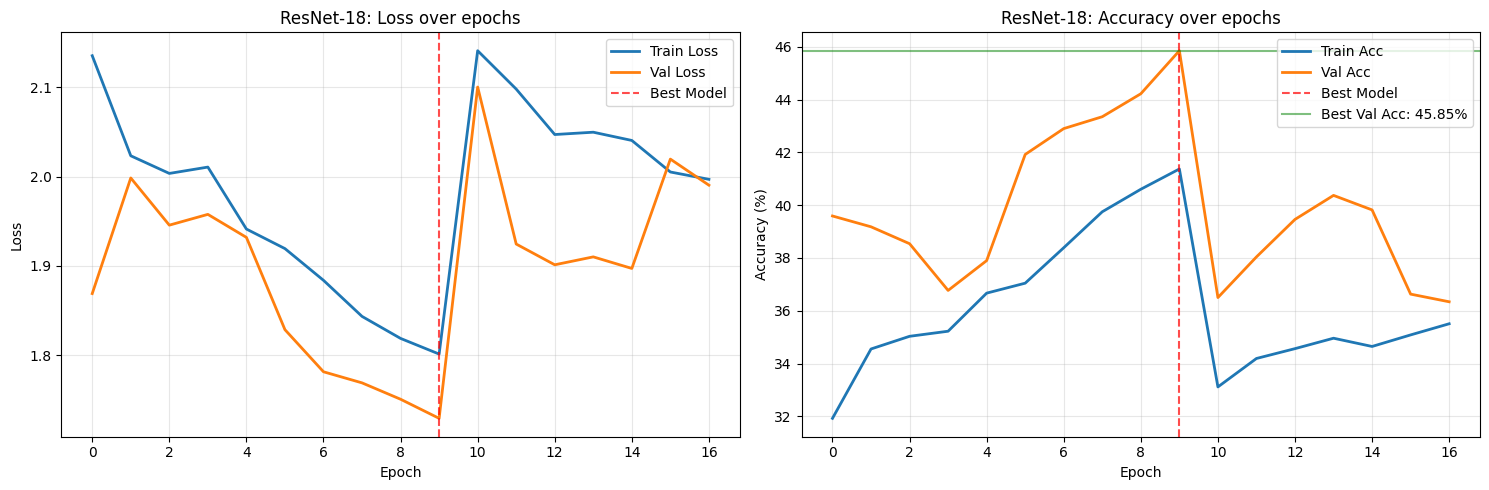


=== Stage 2: Full Network Fine-tuning ===
Starting fine-tuning with method: full
Trainable parameters: 11,173,962

Epoch 1/1000
--------------------------------------------------


Validation: 100%|██████████| 79/79 [00:03<00:00, 20.77it/s, Loss=1.046, Acc=77.86%]


 New best model saved with validation accuracy: 77.86%
Train Loss: 1.3772, Train Acc: 61.49%
Val Loss: 1.0458, Val Acc: 77.86%
Best Val Acc: 77.86%
Learning Rate: 0.000098
Early Stop Counter: 0/10

Epoch 2/1000
--------------------------------------------------


Validation: 100%|██████████| 79/79 [00:03<00:00, 20.68it/s, Loss=0.901, Acc=83.83%]


 New best model saved with validation accuracy: 83.83%
Train Loss: 1.0724, Train Acc: 75.46%
Val Loss: 0.9011, Val Acc: 83.83%
Best Val Acc: 83.83%
Learning Rate: 0.000091
Early Stop Counter: 0/10

Epoch 3/1000
--------------------------------------------------


Validation: 100%|██████████| 79/79 [00:03<00:00, 20.91it/s, Loss=0.849, Acc=86.24%]


 New best model saved with validation accuracy: 86.24%
Train Loss: 0.9575, Train Acc: 80.78%
Val Loss: 0.8488, Val Acc: 86.24%
Best Val Acc: 86.24%
Learning Rate: 0.000080
Early Stop Counter: 0/10

Epoch 4/1000
--------------------------------------------------


Validation: 100%|██████████| 79/79 [00:03<00:00, 21.41it/s, Loss=0.796, Acc=88.14%]


 New best model saved with validation accuracy: 88.14%
Train Loss: 0.8886, Train Acc: 83.76%
Val Loss: 0.7958, Val Acc: 88.14%
Best Val Acc: 88.14%
Learning Rate: 0.000066
Early Stop Counter: 0/10

Epoch 5/1000
--------------------------------------------------


Validation: 100%|██████████| 79/79 [00:03<00:00, 20.23it/s, Loss=0.767, Acc=89.48%]


 New best model saved with validation accuracy: 89.48%
Train Loss: 0.8381, Train Acc: 85.92%
Val Loss: 0.7674, Val Acc: 89.48%
Best Val Acc: 89.48%
Learning Rate: 0.000051
Early Stop Counter: 0/10

Epoch 6/1000
--------------------------------------------------


Validation: 100%|██████████| 79/79 [00:03<00:00, 20.84it/s, Loss=0.744, Acc=90.43%]


 New best model saved with validation accuracy: 90.43%
Train Loss: 0.8049, Train Acc: 87.57%
Val Loss: 0.7436, Val Acc: 90.43%
Best Val Acc: 90.43%
Learning Rate: 0.000035
Early Stop Counter: 0/10

Epoch 7/1000
--------------------------------------------------


Validation: 100%|██████████| 79/79 [00:03<00:00, 20.16it/s, Loss=0.739, Acc=90.48%]


 New best model saved with validation accuracy: 90.48%
Train Loss: 0.7744, Train Acc: 89.06%
Val Loss: 0.7385, Val Acc: 90.48%
Best Val Acc: 90.48%
Learning Rate: 0.000021
Early Stop Counter: 0/10

Epoch 8/1000
--------------------------------------------------


Validation: 100%|██████████| 79/79 [00:03<00:00, 20.66it/s, Loss=0.722, Acc=91.33%]


 New best model saved with validation accuracy: 91.33%
Train Loss: 0.7532, Train Acc: 89.79%
Val Loss: 0.7223, Val Acc: 91.33%
Best Val Acc: 91.33%
Learning Rate: 0.000010
Early Stop Counter: 0/10

Epoch 9/1000
--------------------------------------------------


Validation: 100%|██████████| 79/79 [00:03<00:00, 20.64it/s, Loss=0.718, Acc=91.42%]


 New best model saved with validation accuracy: 91.42%
Train Loss: 0.7435, Train Acc: 90.28%
Val Loss: 0.7177, Val Acc: 91.42%
Best Val Acc: 91.42%
Learning Rate: 0.000003
Early Stop Counter: 0/10

Epoch 10/1000
--------------------------------------------------


Validation: 100%|██████████| 79/79 [00:03<00:00, 20.42it/s, Loss=0.718, Acc=91.51%]


 New best model saved with validation accuracy: 91.51%
Train Loss: 0.7351, Train Acc: 90.67%
Val Loss: 0.7184, Val Acc: 91.51%
Best Val Acc: 91.51%
Learning Rate: 0.000100
Early Stop Counter: 0/10

Epoch 11/1000
--------------------------------------------------


Validation: 100%|██████████| 79/79 [00:03<00:00, 20.64it/s, Loss=0.739, Acc=90.52%]


 No improvement for 1 epoch(s)
Train Loss: 0.7869, Train Acc: 88.41%
Val Loss: 0.7392, Val Acc: 90.52%
Best Val Acc: 91.51%
Learning Rate: 0.000099
Early Stop Counter: 1/10

Epoch 12/1000
--------------------------------------------------


Validation: 100%|██████████| 79/79 [00:03<00:00, 20.62it/s, Loss=0.721, Acc=91.02%]


 No improvement for 2 epoch(s)
Train Loss: 0.7613, Train Acc: 89.39%
Val Loss: 0.7209, Val Acc: 91.02%
Best Val Acc: 91.51%
Learning Rate: 0.000098
Early Stop Counter: 2/10

Epoch 13/1000
--------------------------------------------------


Validation: 100%|██████████| 79/79 [00:03<00:00, 20.84it/s, Loss=0.707, Acc=91.57%]


 New best model saved with validation accuracy: 91.57%
Train Loss: 0.7431, Train Acc: 89.92%
Val Loss: 0.7074, Val Acc: 91.57%
Best Val Acc: 91.57%
Learning Rate: 0.000095
Early Stop Counter: 0/10

Epoch 14/1000
--------------------------------------------------


Validation: 100%|██████████| 79/79 [00:03<00:00, 20.66it/s, Loss=0.702, Acc=91.84%]


 New best model saved with validation accuracy: 91.84%
Train Loss: 0.7207, Train Acc: 91.04%
Val Loss: 0.7023, Val Acc: 91.84%
Best Val Acc: 91.84%
Learning Rate: 0.000091
Early Stop Counter: 0/10

Epoch 15/1000
--------------------------------------------------


Validation: 100%|██████████| 79/79 [00:03<00:00, 20.69it/s, Loss=0.691, Acc=92.16%]


 New best model saved with validation accuracy: 92.16%
Train Loss: 0.7006, Train Acc: 91.95%
Val Loss: 0.6911, Val Acc: 92.16%
Best Val Acc: 92.16%
Learning Rate: 0.000086
Early Stop Counter: 0/10

Epoch 16/1000
--------------------------------------------------


Validation: 100%|██████████| 79/79 [00:03<00:00, 21.19it/s, Loss=0.683, Acc=92.59%]


 New best model saved with validation accuracy: 92.59%
Train Loss: 0.6837, Train Acc: 92.69%
Val Loss: 0.6833, Val Acc: 92.59%
Best Val Acc: 92.59%
Learning Rate: 0.000080
Early Stop Counter: 0/10

Epoch 17/1000
--------------------------------------------------


Validation: 100%|██████████| 79/79 [00:03<00:00, 21.12it/s, Loss=0.678, Acc=92.78%]


 New best model saved with validation accuracy: 92.78%
Train Loss: 0.6689, Train Acc: 93.36%
Val Loss: 0.6782, Val Acc: 92.78%
Best Val Acc: 92.78%
Learning Rate: 0.000073
Early Stop Counter: 0/10

Epoch 18/1000
--------------------------------------------------


Validation: 100%|██████████| 79/79 [00:03<00:00, 20.59it/s, Loss=0.672, Acc=93.22%]


 New best model saved with validation accuracy: 93.22%
Train Loss: 0.6585, Train Acc: 93.78%
Val Loss: 0.6724, Val Acc: 93.22%
Best Val Acc: 93.22%
Learning Rate: 0.000066
Early Stop Counter: 0/10

Epoch 19/1000
--------------------------------------------------


Validation: 100%|██████████| 79/79 [00:03<00:00, 21.58it/s, Loss=0.666, Acc=93.41%]


 New best model saved with validation accuracy: 93.41%
Train Loss: 0.6431, Train Acc: 94.53%
Val Loss: 0.6657, Val Acc: 93.41%
Best Val Acc: 93.41%
Learning Rate: 0.000058
Early Stop Counter: 0/10

Epoch 20/1000
--------------------------------------------------


Validation: 100%|██████████| 79/79 [00:03<00:00, 21.89it/s, Loss=0.661, Acc=93.71%]


 New best model saved with validation accuracy: 93.71%
Train Loss: 0.6305, Train Acc: 95.03%
Val Loss: 0.6607, Val Acc: 93.71%
Best Val Acc: 93.71%
Learning Rate: 0.000051
Early Stop Counter: 0/10

Epoch 21/1000
--------------------------------------------------


Validation: 100%|██████████| 79/79 [00:03<00:00, 20.15it/s, Loss=0.657, Acc=93.53%]


 No improvement for 1 epoch(s)
Train Loss: 0.6226, Train Acc: 95.44%
Val Loss: 0.6568, Val Acc: 93.53%
Best Val Acc: 93.71%
Learning Rate: 0.000043
Early Stop Counter: 1/10

Epoch 22/1000
--------------------------------------------------


Validation: 100%|██████████| 79/79 [00:03<00:00, 22.00it/s, Loss=0.651, Acc=93.86%]


 New best model saved with validation accuracy: 93.86%
Train Loss: 0.6111, Train Acc: 95.91%
Val Loss: 0.6513, Val Acc: 93.86%
Best Val Acc: 93.86%
Learning Rate: 0.000035
Early Stop Counter: 0/10

Epoch 23/1000
--------------------------------------------------


Validation: 100%|██████████| 79/79 [00:03<00:00, 21.35it/s, Loss=0.648, Acc=94.23%]


 New best model saved with validation accuracy: 94.23%
Train Loss: 0.6037, Train Acc: 96.26%
Val Loss: 0.6482, Val Acc: 94.23%
Best Val Acc: 94.23%
Learning Rate: 0.000028
Early Stop Counter: 0/10

Epoch 24/1000
--------------------------------------------------


Validation: 100%|██████████| 79/79 [00:03<00:00, 21.34it/s, Loss=0.645, Acc=94.22%]


 No improvement for 1 epoch(s)
Train Loss: 0.5959, Train Acc: 96.68%
Val Loss: 0.6454, Val Acc: 94.22%
Best Val Acc: 94.23%
Learning Rate: 0.000021
Early Stop Counter: 1/10

Epoch 25/1000
--------------------------------------------------


Validation: 100%|██████████| 79/79 [00:03<00:00, 21.67it/s, Loss=0.646, Acc=94.00%]


 No improvement for 2 epoch(s)
Train Loss: 0.5918, Train Acc: 96.86%
Val Loss: 0.6455, Val Acc: 94.00%
Best Val Acc: 94.23%
Learning Rate: 0.000015
Early Stop Counter: 2/10

Epoch 26/1000
--------------------------------------------------


Validation: 100%|██████████| 79/79 [00:03<00:00, 21.15it/s, Loss=0.641, Acc=94.26%]


 New best model saved with validation accuracy: 94.26%
Train Loss: 0.5858, Train Acc: 97.13%
Val Loss: 0.6410, Val Acc: 94.26%
Best Val Acc: 94.26%
Learning Rate: 0.000010
Early Stop Counter: 0/10

Epoch 27/1000
--------------------------------------------------


Validation: 100%|██████████| 79/79 [00:03<00:00, 21.57it/s, Loss=0.640, Acc=94.35%]


 New best model saved with validation accuracy: 94.35%
Train Loss: 0.5827, Train Acc: 97.28%
Val Loss: 0.6396, Val Acc: 94.35%
Best Val Acc: 94.35%
Learning Rate: 0.000006
Early Stop Counter: 0/10

Epoch 28/1000
--------------------------------------------------


Validation: 100%|██████████| 79/79 [00:03<00:00, 21.79it/s, Loss=0.641, Acc=94.36%]


 New best model saved with validation accuracy: 94.36%
Train Loss: 0.5803, Train Acc: 97.37%
Val Loss: 0.6405, Val Acc: 94.36%
Best Val Acc: 94.36%
Learning Rate: 0.000003
Early Stop Counter: 0/10

Epoch 29/1000
--------------------------------------------------


Validation: 100%|██████████| 79/79 [00:03<00:00, 21.59it/s, Loss=0.639, Acc=94.35%]


 No improvement for 1 epoch(s)
Train Loss: 0.5771, Train Acc: 97.50%
Val Loss: 0.6386, Val Acc: 94.35%
Best Val Acc: 94.36%
Learning Rate: 0.000002
Early Stop Counter: 1/10

Epoch 30/1000
--------------------------------------------------


Validation: 100%|██████████| 79/79 [00:03<00:00, 21.20it/s, Loss=0.637, Acc=94.40%]


 New best model saved with validation accuracy: 94.40%
Train Loss: 0.5763, Train Acc: 97.52%
Val Loss: 0.6373, Val Acc: 94.40%
Best Val Acc: 94.40%
Learning Rate: 0.000100
Early Stop Counter: 0/10

Epoch 31/1000
--------------------------------------------------


Validation: 100%|██████████| 79/79 [00:03<00:00, 21.86it/s, Loss=0.676, Acc=93.13%]


 No improvement for 1 epoch(s)
Train Loss: 0.6375, Train Acc: 94.68%
Val Loss: 0.6765, Val Acc: 93.13%
Best Val Acc: 94.40%
Learning Rate: 0.000100
Early Stop Counter: 1/10

Epoch 32/1000
--------------------------------------------------


Validation: 100%|██████████| 79/79 [00:03<00:00, 21.13it/s, Loss=0.672, Acc=93.02%]


 No improvement for 2 epoch(s)
Train Loss: 0.6343, Train Acc: 94.76%
Val Loss: 0.6716, Val Acc: 93.02%
Best Val Acc: 94.40%
Learning Rate: 0.000099
Early Stop Counter: 2/10

Epoch 33/1000
--------------------------------------------------


Validation: 100%|██████████| 79/79 [00:03<00:00, 21.33it/s, Loss=0.668, Acc=93.21%]


 No improvement for 3 epoch(s)
Train Loss: 0.6280, Train Acc: 95.03%
Val Loss: 0.6684, Val Acc: 93.21%
Best Val Acc: 94.40%
Learning Rate: 0.000099
Early Stop Counter: 3/10

Epoch 34/1000
--------------------------------------------------


Validation: 100%|██████████| 79/79 [00:03<00:00, 21.24it/s, Loss=0.659, Acc=93.55%]


 No improvement for 4 epoch(s)
Train Loss: 0.6177, Train Acc: 95.51%
Val Loss: 0.6595, Val Acc: 93.55%
Best Val Acc: 94.40%
Learning Rate: 0.000098
Early Stop Counter: 4/10

Epoch 35/1000
--------------------------------------------------


Validation: 100%|██████████| 79/79 [00:03<00:00, 21.25it/s, Loss=0.666, Acc=93.49%]


 No improvement for 5 epoch(s)
Train Loss: 0.6157, Train Acc: 95.49%
Val Loss: 0.6660, Val Acc: 93.49%
Best Val Acc: 94.40%
Learning Rate: 0.000096
Early Stop Counter: 5/10

Epoch 36/1000
--------------------------------------------------


Validation: 100%|██████████| 79/79 [00:03<00:00, 20.44it/s, Loss=0.653, Acc=93.99%]


 No improvement for 6 epoch(s)
Train Loss: 0.6056, Train Acc: 96.06%
Val Loss: 0.6530, Val Acc: 93.99%
Best Val Acc: 94.40%
Learning Rate: 0.000095
Early Stop Counter: 6/10

Epoch 37/1000
--------------------------------------------------


Validation: 100%|██████████| 79/79 [00:03<00:00, 21.48it/s, Loss=0.655, Acc=93.62%]


 No improvement for 7 epoch(s)
Train Loss: 0.5981, Train Acc: 96.28%
Val Loss: 0.6553, Val Acc: 93.62%
Best Val Acc: 94.40%
Learning Rate: 0.000093
Early Stop Counter: 7/10

Epoch 38/1000
--------------------------------------------------


Validation: 100%|██████████| 79/79 [00:03<00:00, 21.35it/s, Loss=0.650, Acc=93.94%]


 No improvement for 8 epoch(s)
Train Loss: 0.5901, Train Acc: 96.64%
Val Loss: 0.6499, Val Acc: 93.94%
Best Val Acc: 94.40%
Learning Rate: 0.000091
Early Stop Counter: 8/10

Epoch 39/1000
--------------------------------------------------


Validation: 100%|██████████| 79/79 [00:03<00:00, 21.78it/s, Loss=0.652, Acc=93.89%]


 No improvement for 9 epoch(s)
Train Loss: 0.5912, Train Acc: 96.64%
Val Loss: 0.6516, Val Acc: 93.89%
Best Val Acc: 94.40%
Learning Rate: 0.000088
Early Stop Counter: 9/10

Epoch 40/1000
--------------------------------------------------


Validation: 100%|██████████| 79/79 [00:03<00:00, 22.01it/s, Loss=0.648, Acc=93.95%]


 No improvement for 10 epoch(s)
Early stopping: No improvement for 10 consecutive epochs
Train Loss: 0.5836, Train Acc: 96.93%
Val Loss: 0.6483, Val Acc: 93.95%
Best Val Acc: 94.40%
Learning Rate: 0.000086
Early Stop Counter: 10/10
Early stopping triggered after 40 epochs

Training completed! Best validation accuracy: 94.40%


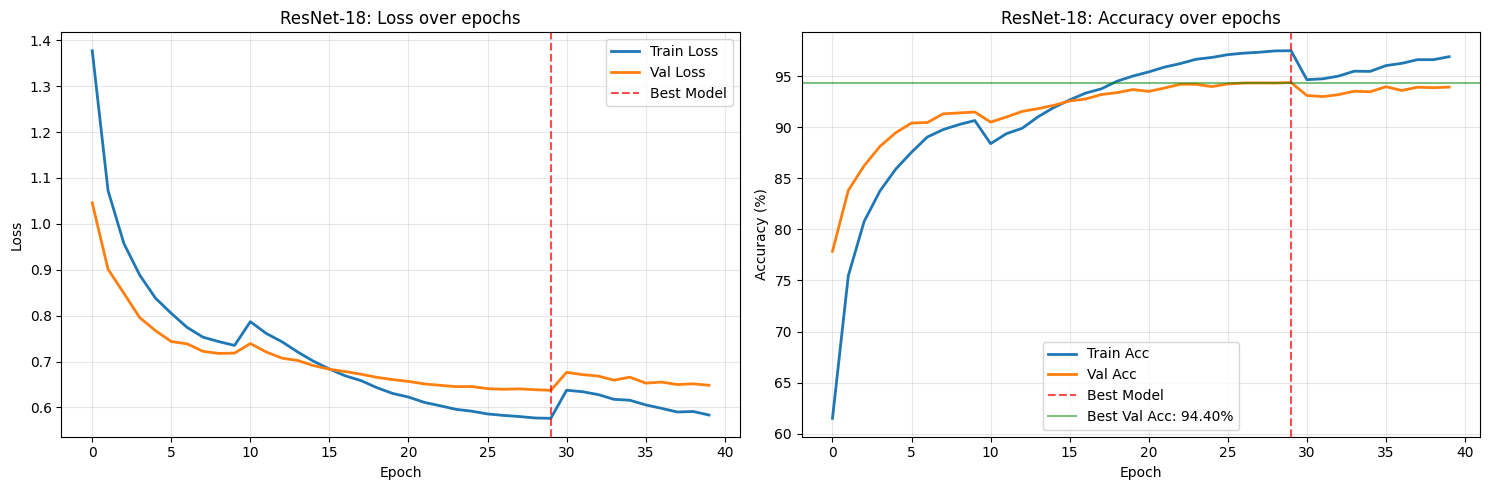

In [10]:
# Choose your fine-tuning strategy:
# Option 1: Direct full fine-tuning
#print("=== Full Fine-tuning Strategy ===")
#model = create_resnet18_model(
#    num_classes=10, 
#    pretrained=True, 
#    fine_tune_method='full'  # Options: 'full', 'last_layer', 'progressive'
#)

#model, checkpoint = fine_tune_resnet(
#    model, train_loader, val_loader,
#    epochs=1000, initial_lr=0.001, fine_tune_method='full', patience=10
#)

# Option 2: Two-stage fine-tuning (uncomment to use)
print("=== Two-Stage Fine-tuning Strategy ===")
model, checkpoint = two_stage_fine_tuning()

# Option 3: Progressive unfreezing (uncomment to use)
#print("=== Progressive Unfreezing Strategy ===")
#model = create_resnet18_model(
# num_classes=10, 
 #pretrained=True, 
# fine_tune_method='progressive'
#)
#model, checkpoint = fine_tune_resnet(
# model, train_loader, val_loader,
# epochs=1000, initial_lr=0.001, fine_tune_method='progressive', patience=12
#)

# Prediction and Submission

In [11]:
def create_submission(model, test_loader, use_tta=True):
    """
    Create submission with optional Test Time Augmentation
    """
    model.eval()
    
    if use_tta:
        print("Using Test Time Augmentation (TTA)")
        predictions, image_ids = predict_with_tta(model, test_loader)
    else:
        print("Using standard prediction")
        predictions, image_ids = predict_standard(model, test_loader)
    
    # Map predictions to class names
    class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 
                   'dog', 'frog', 'horse', 'ship', 'truck']
    predicted_labels = [class_names[pred] for pred in predictions]
    
    # Create submission
    submission = pd.DataFrame({
        'id': image_ids,
        'label': predicted_labels
    })
    submission = submission.sort_values('id').reset_index(drop=True)
    
    submission.to_csv('/kaggle/working/resnet18_submission.csv', index=False)
    print(f"Submission created with {len(submission)} predictions")
    print(submission.head(10))
    
    return submission

def predict_standard(model, test_loader):
    predictions = []
    image_ids = []
    
    with torch.no_grad():
        pbar = tqdm(test_loader, desc="Standard Prediction")
        for inputs, img_ids in pbar:
            inputs = inputs.to(device, non_blocking=True)
            outputs = model(inputs)
            _, predicted = outputs.max(1)
            predictions.extend(predicted.cpu().numpy())
            image_ids.extend(img_ids.numpy())
    
    return predictions, image_ids

def predict_with_tta(model, test_loader, n_augments=5):
    """
    Test Time Augmentation with multiple transforms
    """
    model.eval()
    
    # Define TTA transforms
    tta_transforms = [
        val_transform,  # original
        transforms.Compose([
            transforms.RandomHorizontalFlip(p=1.0),
            transforms.ToTensor(),
            transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
        ]),
        transforms.Compose([
            transforms.RandomRotation(10),
            transforms.ToTensor(),
            transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
        ])
    ]
    
    all_predictions = []
    image_ids = []
    
    with torch.no_grad():
        pbar = tqdm(test_loader, desc="TTA Prediction")
        for batch_idx, (inputs, img_ids) in enumerate(pbar):
            batch_predictions = []
            
            for transform in tta_transforms[:n_augments]:
                # Apply TTA transforms
                augmented_batch = []
                for img in inputs:
                    # Convert tensor to PIL for transformation
                    img_pil = transforms.ToPILImage()(img)
                    img_transformed = transform(img_pil)
                    augmented_batch.append(img_transformed)
                
                augmented_inputs = torch.stack(augmented_batch).to(device, non_blocking=True)
                outputs = model(augmented_inputs)
                batch_predictions.append(outputs.softmax(1).cpu().numpy())
            
            # Average predictions
            avg_predictions = np.mean(batch_predictions, axis=0)
            final_predictions = np.argmax(avg_predictions, axis=1)
            
            all_predictions.extend(final_predictions)
            image_ids.extend(img_ids.numpy())
    
    return all_predictions, image_ids

In [12]:
# Create final submission
print("\n=== Creating Final Submission ===")
submission = create_submission(model, test_loader, use_tta=False)


=== Creating Final Submission ===
Using standard prediction


Standard Prediction: 100%|██████████| 2344/2344 [01:23<00:00, 28.05it/s]


Submission created with 300000 predictions
   id       label
0   1         cat
1   2    airplane
2   3  automobile
3   4        ship
4   5    airplane
5   6         cat
6   7    airplane
7   8       truck
8   9        bird
9  10         cat
